In [1]:
import tensorflow as tf
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
import warnings
import tqdm
warnings.filterwarnings('ignore')

C:\Users\PLCRCRD19\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Loading model

In [2]:
# Load graph data
loader = tf.train.import_meta_graph('saved_model/classifier.ckpt.meta')
sess = tf.Session()
loader.restore(sess,'saved_model/classifier.ckpt')
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from saved_model/classifier.ckpt


In [3]:
# Find relevant ops
assert len([op.name for op in graph.get_operations() if 'output' in op.name or 'features' in op.name]) == 2
assert len([op.name for op in graph.get_operations() if 'cnn_' in op.name]) == 0
print([op.name for op in graph.get_operations() if 'output' in op.name or 'features' in op.name])

['features', 'output']


In [4]:
# Grab them
x = graph.get_tensor_by_name('features:0')
y = graph.get_tensor_by_name('output:0')

# Testing model accuracy (just in case)

In [5]:
test_image = skimage.transform.resize(plt.imread('train/dog.0.jpg'), (128,128,1))
res = sess.run(y, feed_dict={x: [test_image]})
answer = 'cat' if res[0][0]>res[0][1] else 'dog'
print(f'{res[0]} - {answer}')

[0.27647346 0.72352654] - dog


In [6]:
def calculate_accuracy():
    counter = 0
    for i in tqdm.trange(1000):
        animal = 'cat' if i%2==0 else 'dog'
        test_image = skimage.transform.resize(plt.imread(f'train/{animal}.{i}.jpg'), (128,128,1))
        res = sess.run(y, feed_dict={x: [test_image]})
        answer = 'cat' if res[0][0]>res[0][1] else 'dog'
        if answer == animal:
            counter+=1
    return counter
      
counter = calculate_accuracy()
print(f'{counter/10}% accuracy')

100%|██████████████████████████████████████| 1000/1000 [00:24<00:00, 40.34it/s]


77.4% accuracy


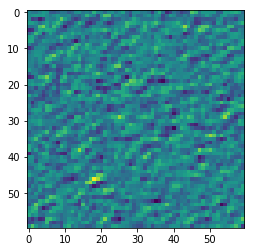

In [27]:
def T(layer):
    return graph.get_tensor_by_name(f'{layer}:0')

img = np.random.uniform(size=(1,128,128,1)) + 100.0
res = sess.run(T('cnn/classificator/convolution/conv2d/Conv2D'), feed_dict={x: img})
# res.T.shape
res = res.T
res = res/np.max(res)
plt.imshow(res[0][:,:,0])

# Dreaming!

In [13]:
print([op.name for op in graph.get_operations() if 'Conv2D' in op.name and 'training' not in op.name])

['cnn/classificator/convolution/layer1/Conv2D', 'cnn/classificator/convolution/conv2d/Conv2D', 'cnn/classificator/convolution/conv2d_1/Conv2D', 'cnn/classificator/convolution/conv2d_2/Conv2D', 'cnn/classificator/convolution/layer-1/Conv2D']


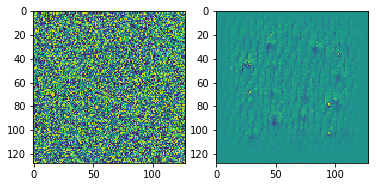

In [61]:
layer = 'cnn/classificator/convolution/conv2d_2/Conv2D'
feature = 5

np.random.seed(0)
img_noise = np.random.uniform(size=(1,128,128,1)) + 100.0

def showarray(a, fmt='jpeg'):
    a = a/np.max(a)
    plt.imshow(a[0,:,:,0])
    
def norm(a, s=0.1):
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def replace_none_with_zero(l):
    return [0 if i==None else i for i in l] 

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj)
    t_grad = tf.gradients(t_obj, x)[0]
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {x:img})
        
        g /= g.std()+1e-8         
        img += g*step
#         print(score)
    showarray(norm(img))
        
    return img

op = T(layer)
plt.subplot(121)
plt.imshow(img_noise[0,:,:,0])
plt.subplot(122)
img = render_naive(op[:,:,:,feature])

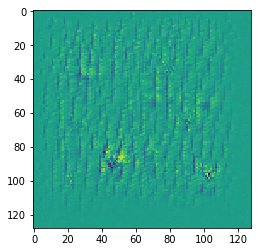

In [73]:
layer = 'cnn/classificator/convolution/conv2d_2/Conv2D'
feature = 13

img_noise = np.random.uniform(size=(1,128,128,1)) + 100.0
render_naive(op[:,:,:,feature], img0=img_noise);